In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import fbprophet
from fbprophet import Prophet
# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import os
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

In [ ]:
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22799 (delta 11), reused 18 (delta 9), pack-reused 22773
Receiving objects: 100% (22799/22799), 99.45 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (12378/12378), done.


In [ ]:

confirmed_cases_url = "/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_cases_url ="/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_cases_url ="/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [ ]:
def get_n_melt_data(data_url,case_type):
    df = pd.read_csv(data_url)
    melted_df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type},inplace=True)
    return melted_df

def merge_data(confirm_df,recovered_df,deaths_df):

	new_df = confirm_df.join(deaths_df['Deaths']).join(recovered_df['Recovered'])
	return new_df

In [ ]:
confirm_df = get_n_melt_data(confirmed_cases_url,"Confirmed")
recovered_df = get_n_melt_data(recovered_cases_url,"Recovered")
deaths_df = get_n_melt_data(death_cases_url,"Deaths")

In [ ]:
confirm_df

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0
...,...,...,...,...,...,...
25339,Saint Pierre and Miquelon,France,46.885200,-56.315900,4/26/20,1
25340,NaN,South Sudan,6.877000,31.307000,4/26/20,6
25341,NaN,Western Sahara,24.215500,-12.885800,4/26/20,6
25342,NaN,Sao Tome and Principe,0.186360,6.613081,4/26/20,4


In [ ]:
confirm_df['Country/Region'].tolist()

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Australia',
 'Australia',
 'Australia',
 'Australia',
 'Australia',
 'Australia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'China',
 'Colombia',
 'Congo

In [ ]:
Country='Tunisia'
Province='New South Wales'

In [ ]:
confirmed=confirm_df[confirm_df['Country/Region']==Country].reset_index()
recovered=recovered_df[recovered_df['Country/Region']==Country].reset_index()
deaths=deaths_df[deaths_df['Country/Region']==Country].reset_index()
df_t = merge_data(confirmed,recovered,deaths)

In [ ]:
# confirmed=confirm_df[(confirm_df['Country/Region']==Country) & (confirm_df['Province/State']==Province)].reset_index()
# recovered=recovered_df[(recovered_df['Country/Region']==Country) & (confirm_df['Province/State']==Province)].reset_index()
# deaths=deaths_df[(deaths_df['Country/Region']==Country) & (confirm_df['Province/State']==Province)].reset_index()
# df_t = merge_data(confirmed,recovered,deaths)

In [ ]:
df_t = df_t.assign(Date=df_t['Date'].astype(np.datetime64))


In [ ]:
df_t

,index,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,212,NaN,Tunisia,34.0,9.0,2020-01-22,0,0,0
1,476,NaN,Tunisia,34.0,9.0,2020-01-23,0,0,0
2,740,NaN,Tunisia,34.0,9.0,2020-01-24,0,0,0
3,1004,NaN,Tunisia,34.0,9.0,2020-01-25,0,0,0
4,1268,NaN,Tunisia,34.0,9.0,2020-01-26,0,0,0
...,...,...,...,...,...,...,...,...,...
80,21332,NaN,Tunisia,34.0,9.0,2020-04-11,685,28,43
81,21596,NaN,Tunisia,34.0,9.0,2020-04-12,707,31,43
82,21860,NaN,Tunisia,34.0,9.0,2020-04-13,726,34,43
83,22124,NaN,Tunisia,34.0,9.0,2020-04-14,747,34,43


In [ ]:
df_melt =country_df = df_t.groupby(['Date']).sum() \
.reset_index() \
.melt(id_vars='Date', value_vars=['Confirmed', 'Deaths','Recovered']) \
    .sort_values('Date')
px.line(df_melt, 
        x='Date', 
        y='value' , 
        color='variable', 
        line_shape="spline", 
        render_mode="svg", 
         template='plotly_dark'
)

In [ ]:
df_t[df_t['Confirmed']==2]

,index,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
46,12356,NaN,Tunisia,34.0,9.0,2020-03-08,2,0,0
47,12620,NaN,Tunisia,34.0,9.0,2020-03-09,2,0,0


In [ ]:
confirmed_cases = df_t[["Date","Confirmed"]]
Deaths_cases = df_t[["Date","Deaths"]]
Recovered_cases=df_t[["Date","Recovered"]]

In [ ]:
confirmed_cases.rename(columns={"Date":"ds","Confirmed":"y"},inplace=True)
Deaths_cases.rename(columns={"Date":"ds","Deaths":"y"},inplace=True)
Recovered_cases.rename(columns={"Date":"ds","Recovered":"y"},inplace=True)


In [ ]:
def predect(confirmed_cases):
  m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
  m.add_seasonality(name="monthly",period=30.5,fourier_order=50)
  m.fit(confirmed_cases)
  future_dates = m.make_future_dataframe(periods=200)
  prediction =  m.predict(future_dates)
  m.plot(prediction)
  return prediction

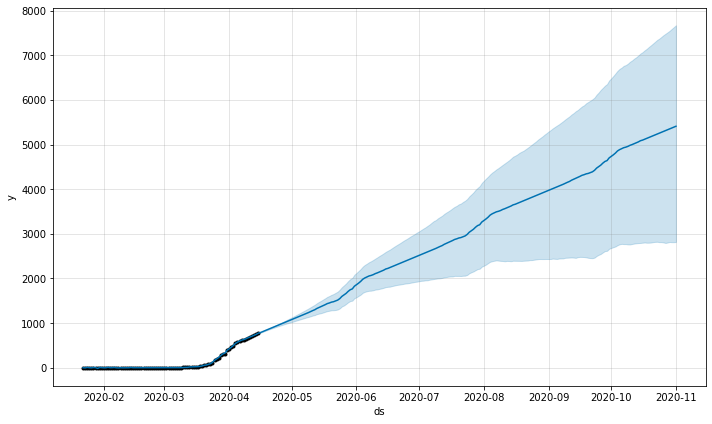

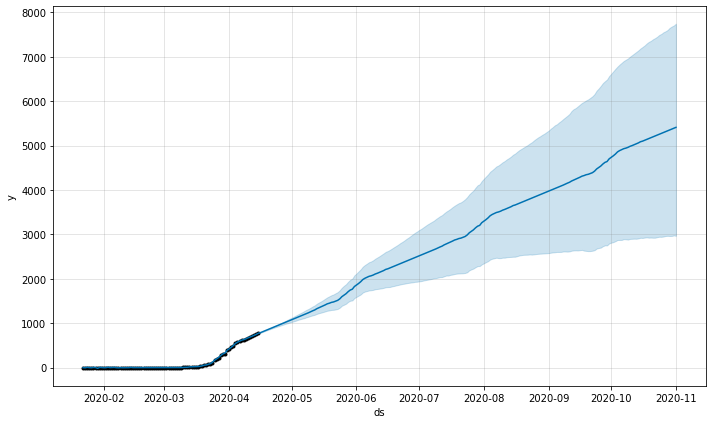

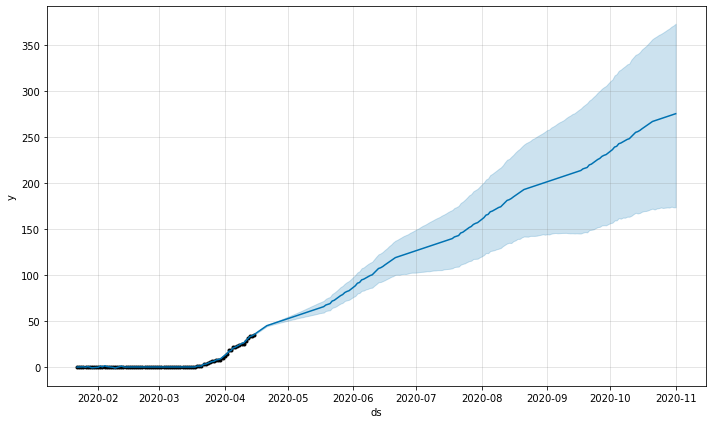

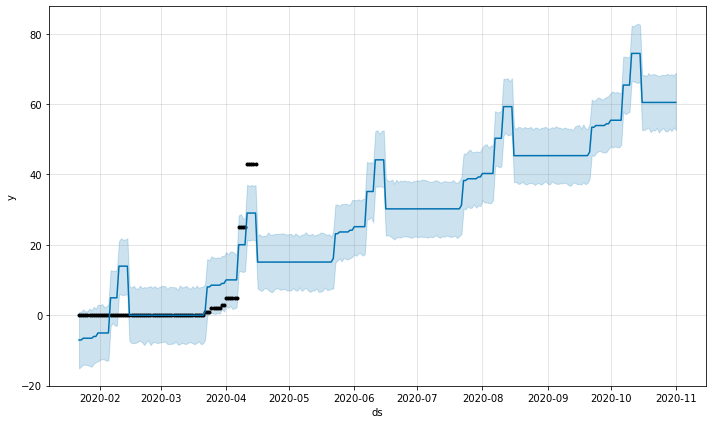

In [ ]:
pred=pd.DataFrame({
    'ds':predect(confirmed_cases)['ds'],
    'confirmedpred':round(predect(confirmed_cases)['yhat']),
    'deathspred':round(predect(Deaths_cases)['yhat']),
    'Recoveredpred':round(predect(Recovered_cases)['yhat'])
})

In [ ]:
pred[50:100]


,ds,confirmedpred,deathspred,Recoveredpred
50,2020-03-12,2.0,-0.0,8.0
51,2020-03-13,7.0,0.0,7.0
52,2020-03-14,8.0,0.0,6.0
53,2020-03-15,9.0,-0.0,7.0
54,2020-03-16,22.0,0.0,3.0
55,2020-03-17,33.0,0.0,-0.0
56,2020-03-18,38.0,0.0,1.0
57,2020-03-19,46.0,1.0,1.0
58,2020-03-20,58.0,1.0,1.0
59,2020-03-21,62.0,1.0,2.0


In [ ]:
df_melt =country_df = pred.groupby(['ds']).sum() \
.reset_index() \
.melt(id_vars='ds', value_vars=['confirmedpred','deathspred','Recoveredpred']) \
    .sort_values('ds')
fig=px.line(df_melt, 
        x='ds', 
        y='value' , 
        color='variable',
        line_shape="spline",title='propagation du covid-19 en'+' '+ Country, 
        render_mode="svg", 
         template='plotly_dark'
)
fig.add_scatter(x=df_t['Date'], y=df_t['Confirmed'],mode='lines',name='Confirmed_real')
fig.add_scatter(x=df_t['Date'], y=df_t['Deaths'],mode='lines',name='Deaths_real')
fig.add_scatter(x=df_t['Date'], y=df_t['Recovered'],mode='lines',name='Recovered_real')

# ARIMA

# **Tunisie**